<font face='Liberation serif' size=4>**Описание:** У нас есть данные из Yandex Billboard, который представляет собой сервис для покупки билетов в кинотеатры, театры, концерты и т. Д. Мы должны рассчитать основные показатели продукта, визуализировать их и придумать идеи, как оптимизировать маркетинговые расходы. </font>

<font face='Liberation serif' size=4>Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов. </font>

<font face='Liberation serif' size=4>**Цель проекта:** оптимизация маркетингового бюджета на основании рассчитанных метрик</font>

In [1]:
#Имортируем все необходимые библиотеки
import datetime as dt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.float.format', lambda x: '%.3f' %x)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML('<style>.container{width:75%! important;}</style>'))
from IPython.display import display, Markdown

### Шаг 1. Загрузим данные и подготовим их к анализу

In [2]:
#Загрузим данные
df_costs = pd.read_csv('/datasets/costs.csv')
df_orders = pd.read_csv('/datasets/orders_log.csv')
df_visits = pd.read_csv('/datasets/visits_log.csv')


def print_info(df):
    df.info()
    display(df.describe())
    display(df)

for df in [df_costs, df_orders, df_visits]:
    print_info(df)
    print('')
    print('-----------------------------------------------------------')
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000,2542.000
mean,4.857,129.477
std,3.182,156.297
min,1.000,0.540
25%,2.000,21.945
50%,4.000,77.295
75%,9.000,170.065
max,10.000,1788.280


,source_id,dt,costs
0,1,2017-06-01,75.200
1,1,2017-06-02,62.250
2,1,2017-06-03,36.530
3,1,2017-06-04,55.000
4,1,2017-06-05,57.080
...,...,...,...
2537,10,2018-05-27,9.920
2538,10,2018-05-28,21.260
2539,10,2018-05-29,11.320
2540,10,2018-05-30,33.150



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000,50415.000
mean,5.000,9098160634289729536.000
std,21.818,5285741550834715648.000
min,0.000,313578113262317.000
25%,1.220,4533566627250599936.000
50%,2.500,9102273602618561536.000
75%,4.890,13682901980465401856.000
max,2633.280,18446167067214817280.000


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.640,12296626599487328624
50411,2018-05-31 23:50:00,5.800,11369640365507475976
50412,2018-05-31 23:54:00,0.300,1786462140797698849
50413,2018-05-31 23:56:00,3.670,3993697860786194247



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000,359400.000
mean,3.751,9202556994354921472.000
std,1.917,5298432824659611648.000
min,1.000,11863502262781.000
25%,3.000,4613406732167550976.000
50%,4.000,9227412908740601856.000
75%,5.000,13728237011236173824.000
max,10.000,18446676030785673216.000


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485



-----------------------------------------------------------



### Представим данные в удобном виде и подготовим их к анализу

In [3]:
for df in [df_costs, df_orders, df_visits]:
    print(df.columns.to_list())

['source_id', 'dt', 'costs']
['Buy Ts', 'Revenue', 'Uid']
['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']


In [4]:
#сделаем имена столбцов строчными
for df in [df_costs, df_orders, df_visits]:
    df.columns = map(str.lower, df.columns)

#переименование столбцов
df_costs = df_costs.rename({'dt':'dt_of_commercial', 'costs':'cost_for_marketing_source'}, 
                           axis='columns')
df_orders = df_orders.rename({'buy ts':'dt_of_order'}, axis='columns')
df_visits = df_visits.rename({'device':'device_cat', 'start ts':'dt_start_of_session',
                              'end ts':'dt_end_of_session', 'source id': 
                              'commercial_source_id'}, 
                             axis = 'columns')

for df in [df_costs, df_orders, df_visits]:
    display(df.columns.to_list())

['source_id', 'dt_of_commercial', 'cost_for_marketing_source']

['dt_of_order', 'revenue', 'uid']

['device_cat',
 'dt_end_of_session',
 'commercial_source_id',
 'dt_start_of_session',
 'uid']

In [5]:
# converting dates to datetime64 and extracting days, weeks, months and years
def make_date_and_add_columns(df, column_name, 
                              date_column_name, week_column_name, 
                              month_column_name, year_column_name):
    '''
        writing a function, which adds days, weeks, months and years
    '''
    df = df.copy()
    df[column_name] = pd.to_datetime(df[column_name])
    df[date_column_name] = df[column_name].astype('datetime64[D]')
    df[week_column_name] = df[column_name].astype('datetime64[W]')
    df[month_column_name] = df[column_name].astype('datetime64[M]')
    df[year_column_name] = df[column_name].astype('datetime64[Y]')
    return df

# applying the function to df_costs   
df_costs = df_costs.pipe(make_date_and_add_columns, 'dt_of_commercial', 
                         'day_of_commercial','week_of_commercial', 
                         'month_of_commercial', 'year_of_commercial')

# we're not sure yet that we need so many columns in other dataframes, so for the other two
# dfs let's only change the data type

def transform_into_date_type(df, columns):
    """transfoorming a column to a datetime64 format"""
    df = df.copy()
    for col in columns: 
        df[col] = pd.to_datetime(df[col])
    return df

# applying it 

df_costs = transform_into_date_type(df_costs, ['dt_of_commercial'])
df_orders = transform_into_date_type(df_orders, ['dt_of_order'])
df_visits = transform_into_date_type(df_visits, ['dt_end_of_session'])

In [6]:
# проверим данные на предмет пропущенных значений и дубликатов
names = {'df_visits': df_visits, 'df_costs': df_costs, 'df_orders': df_orders}
for name, df in names.items():
    print('The number of duplicates in', name, df.duplicated().sum())
    for column in df.columns: 
        print('The number of duplicates in', column, ':', df[column].isna().sum())


The number of duplicates in df_visits 0
The number of duplicates in device_cat : 0
The number of duplicates in dt_end_of_session : 0
The number of duplicates in commercial_source_id : 0
The number of duplicates in dt_start_of_session : 0
The number of duplicates in uid : 0
The number of duplicates in df_costs 0
The number of duplicates in source_id : 0
The number of duplicates in dt_of_commercial : 0
The number of duplicates in cost_for_marketing_source : 0
The number of duplicates in day_of_commercial : 0
The number of duplicates in week_of_commercial : 0
The number of duplicates in month_of_commercial : 0
The number of duplicates in year_of_commercial : 0
The number of duplicates in df_orders 0
The number of duplicates in dt_of_order : 0
The number of duplicates in revenue : 0
The number of duplicates in uid : 0


In [7]:
for df in [df_costs, df_orders, df_visits]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 7 columns):
source_id                    2542 non-null int64
dt_of_commercial             2542 non-null datetime64[ns]
cost_for_marketing_source    2542 non-null float64
day_of_commercial            2542 non-null datetime64[ns]
week_of_commercial           2542 non-null datetime64[ns]
month_of_commercial          2542 non-null datetime64[ns]
year_of_commercial           2542 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(1)
memory usage: 139.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
dt_of_order    50415 non-null datetime64[ns]
revenue        50415 non-null float64
uid            50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device_cat     

<font face='Liberation serif' size=4>**Шаг 2:** Расчет показателей продукта</font>

есть два типа устройств (мобильные / Интернет) и различные типы маркетинговых источников. Мы будем рассчитывать разные метрики в основном для: device_category + marketing_channel

-----------------------------------------------------------------------------------------------------------
Percentage of users, using mobile or/and desktop versions:


desktop   0.731
touch     0.269
Name: device_cat, dtype: float64


-----------------------------------------------------------------------------------------------------------
There are 228169 unique users

-----------------------------------------------------------------------------------------------------------
The earliest session is on the: 2017-06-01 00:01:00 , the latest is on 2018-05-31 23:59:00

-----------------------------------------------------------------------------------------------------------
There are 9 marketing channels and 7 of them are paid


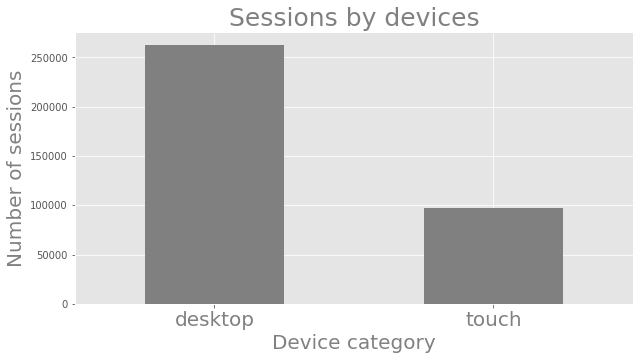

In [8]:
# Расчет показателей вовлеченности и их визуализация
# let's set the style for matplotlib 
plt.style.use('ggplot')

# let's count the ration of sessions by device category
df_visits['device_cat'].value_counts().plot(
                                            kind='bar', figsize=(10,5), 
                                            grid=True, color='grey'
)
plt.title('Sessions by devices', fontsize=25, color='grey')
plt.xlabel('Device category', fontsize=20, color='grey')
plt.ylabel('Number of sessions', fontsize=20, color='grey')
plt.xticks(rotation=0, fontsize=20, color='grey')

print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'Percentage of users, using mobile or/and desktop versions:' + '\033[0m' )
display(df_visits['device_cat'].value_counts(normalize = True))
print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'There are', df_visits['uid'].nunique(), 
      'unique users' + '\033[0m' )

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'The earliest session is on the:' + 
      '\033[0m' , df_visits['dt_start_of_session'].\
      min(),',','\033[1m' + 'the latest is on' + '\033[0m' , 
      df_visits['dt_start_of_session'].max())

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
df_visits['commercial_source_id'].value_counts()
print('\033[1m' + 'There are', df_visits['commercial_source_id'].\
      nunique(),
      'marketing channels and', df_costs['source_id'].nunique(), 
      'of them are paid' + '\033[0m' )

<font face='Liberation serif' size=4>**Сколько людей используют продукт ежедневно, еженедельно, ежемесячно?**</font>

In [9]:
# давайте также конвертируем фрейм данных с посещениями в datetime64 и извлекаем дни,
# недели, месяца и года
df_visits = df_visits.pipe(
                           make_date_and_add_columns, 'dt_start_of_session', 
                           'dt_start_of_session_day','dt_start_of_session_week', 
                           'dt_start_of_session_month', 'dt_start_of_session_year'
)

# расчет показателей вовлеченности пользователей
dau_total = df_visits.groupby('dt_start_of_session_day').\
agg({'uid':'nunique'}).mean().astype(int)
wau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_week']).\
agg({'uid':'nunique'}).mean().astype(int)
mau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_month']).\
agg({'uid':'nunique'}).mean().astype(int)

# для удобной демонстрации информации создадим словарь и воспользуемся циклом

sticky_metrics = {'DAU': dau_total, 'WAU':wau_total, 
                  'MAU':mau_total}
for name,metric in sticky_metrics.items():
    print('\033[1m' + name + '\033[0m',':', int(metric), 'unique users')

# вычисление "sticky"
sticky_wau = dau_total / wau_total * 100
sticky_mau = wau_total/mau_total * 100
print('\033[1m' + 'DAU / WAU =', 
      int(sticky_wau), '%'+ '\033[0m')
print('\033[1m' + 'WAU / MAU =', 
      int(sticky_mau), '%' + '\033[0m')

DAU : 907 unique users
WAU : 5621 unique users
MAU : 23228 unique users
DAU / WAU = 16 %
WAU / MAU = 24 %


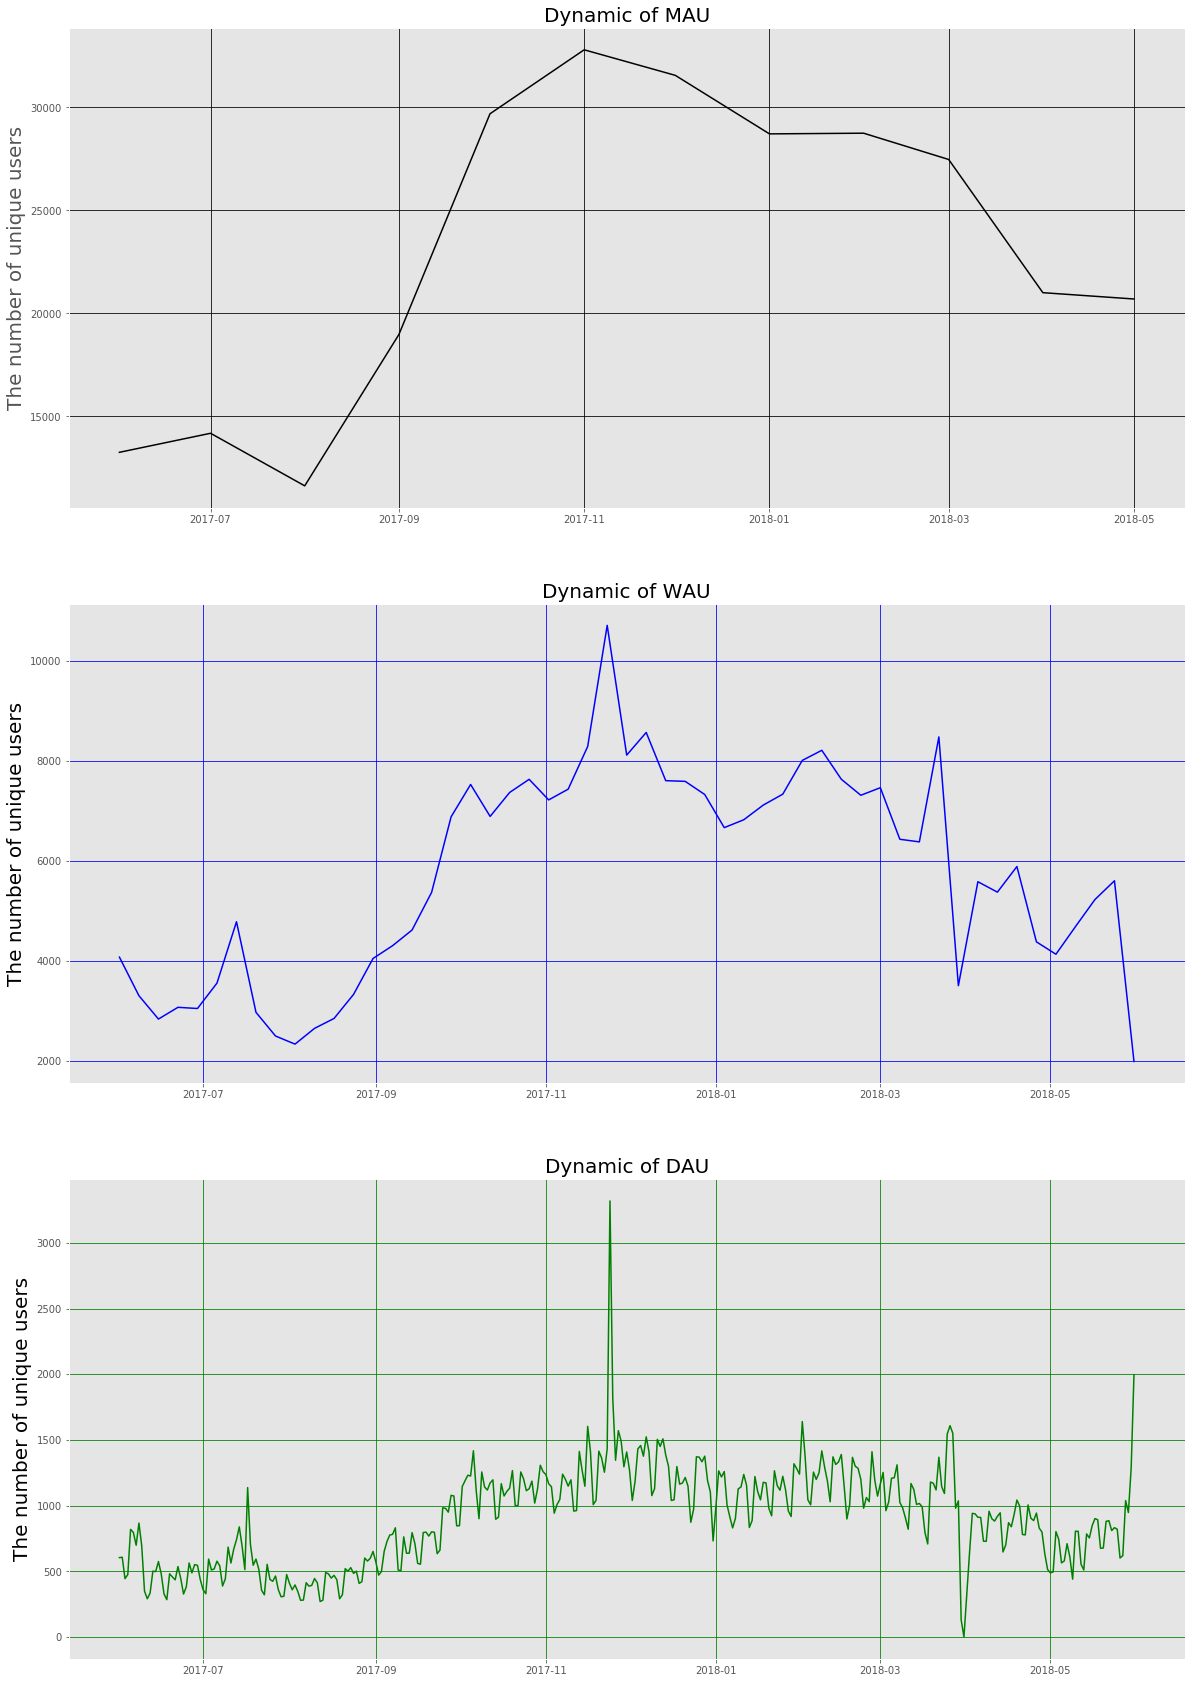

In [10]:
# визуализируем DAU, WAU, MAU
fig,ax = plt.subplots(3,1, figsize=(20, 30))
ax[0].plot(df_visits.groupby('dt_start_of_session_month').\
           agg({'uid':'nunique'}), color='black')
# the first subplot for months 
ax[0].set_ylabel('The number of unique users', fontsize=20)
ax[0].set_title('Dynamic of MAU', fontsize=20, color='black')
ax[0].grid(color='black')

# the second one for weeks
ax[1].plot(df_visits.groupby('dt_start_of_session_week').\
           agg({'uid':'nunique'}), color='b')
ax[1].set_ylabel('The number of unique users', fontsize=20, color='black')
ax[1].set_title('Dynamic of WAU', fontsize=20, color='black')
ax[1].grid(color='blue')

# the third one for days
ax[2].plot(df_visits.groupby('dt_start_of_session_day').\
           agg({'uid': 'nunique'}), color='g')
ax[2].set_ylabel('The number of unique users', fontsize=20, color='black')
ax[2].set_title('Dynamic of DAU', fontsize=20, color='black')
ax[2].grid(color='green')
plt.show()

Понятно, что самыми загруженными месяцами для продукта были ноябрь и декабрь 2017 года. В остальное время показатели оставались примерно стабильными. В конце марта / начале апреля было одно сильное падение.

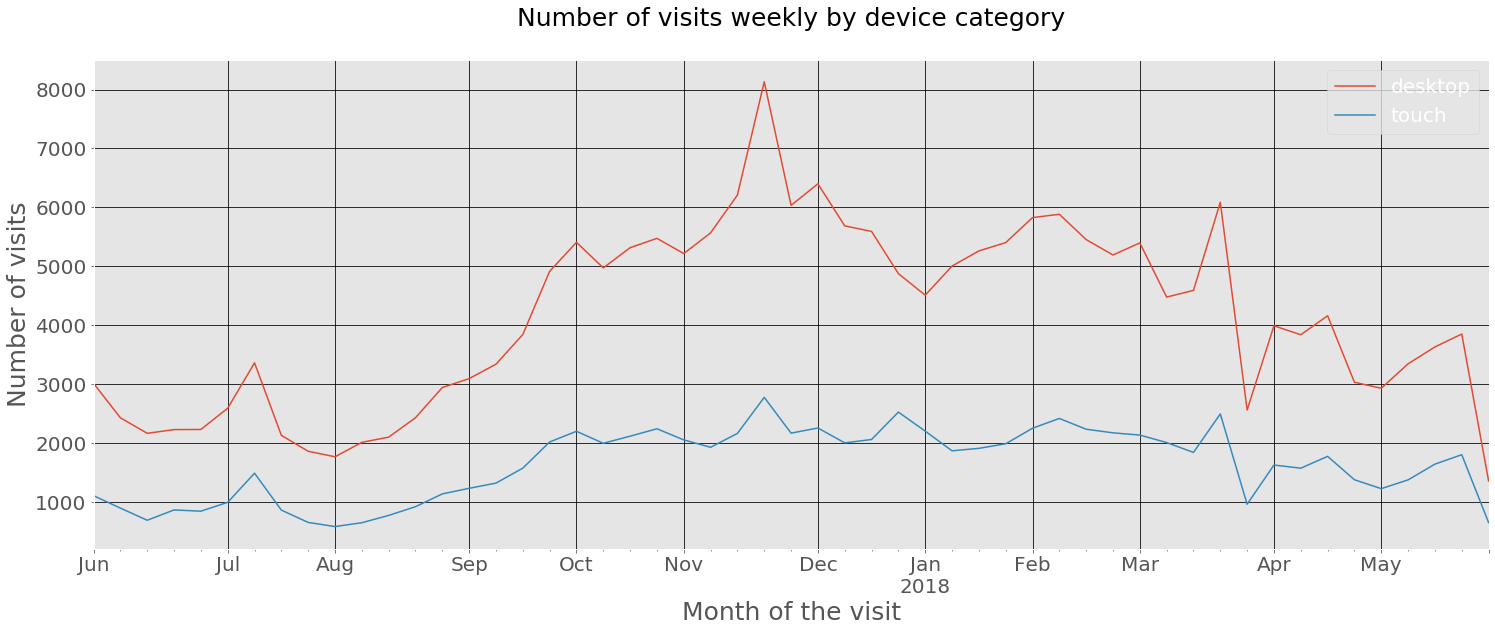

In [11]:
# посмотрим, как посещения распределяются по категориям устройств
df_visits.pivot_table(
                             index='dt_start_of_session_week', values='uid', 
                             columns='device_cat', aggfunc='nunique'
).\
plot(figsize = (25, 9))
plt.title('Number of visits weekly by device category' + '\n', fontsize = 25, color='black')
plt.legend(prop={'size': 20})
plt.ylabel('Number of visits', fontsize = 25)
plt.xlabel('Month of the visit', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(c='black')
plt.show()

Неудивительно, что все большинство пользователей используют продукт с настольных компьютеров

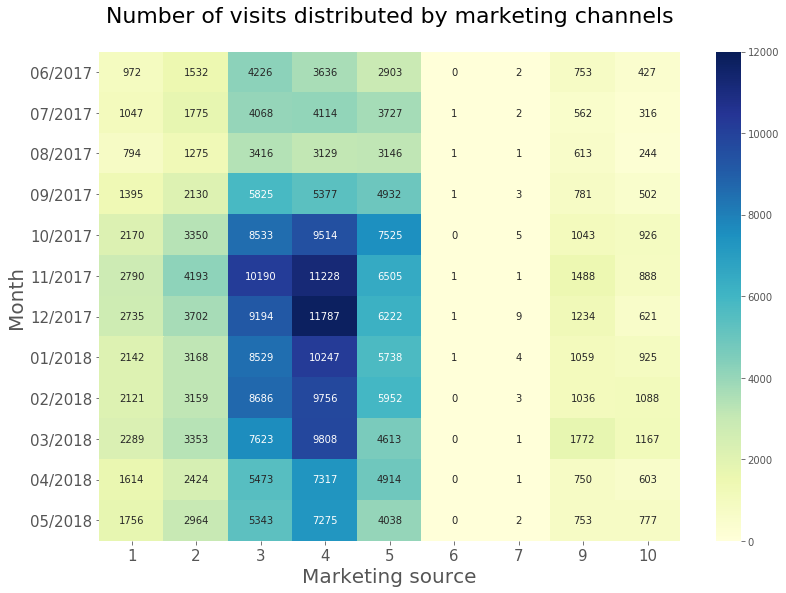

In [12]:
# анализируем маркетинговые каналы. Посчитаем, сколько уникальных пользователей пришло с каждого 
# маркетингового канала
mau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_month', values='uid',
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

# using heatmap
plt.figure(figsize=(13,9))
mau_pivot_with_index = mau_pivot.copy()
mau_pivot_with_index.index = mau_pivot_with_index.index.strftime('%m/%Y')
sns.heatmap(mau_pivot_with_index, cmap="YlGnBu", annot=True, vmin=0,
            vmax=12000, fmt='d')
plt.title('Number of visits distributed by marketing channels' + '\n', 
          fontsize=22, color='black')
plt.ylabel('Month', fontsize=20)
plt.xlabel('Marketing source', fontsize=20)
plt.yticks( fontsize = 15, rotation=0)
plt.xticks(fontsize = 15)
plt.show()

Наибольшее количество потенциальных клиентов поступает из третьего и четвертого маркетингового канала. Еще один вывод, который можно сделать из этого графика, заключается в том, что количество пользователей колеблется в зависимости от сезона. Наибольшее количество посетителей было в ноябре и декабре.

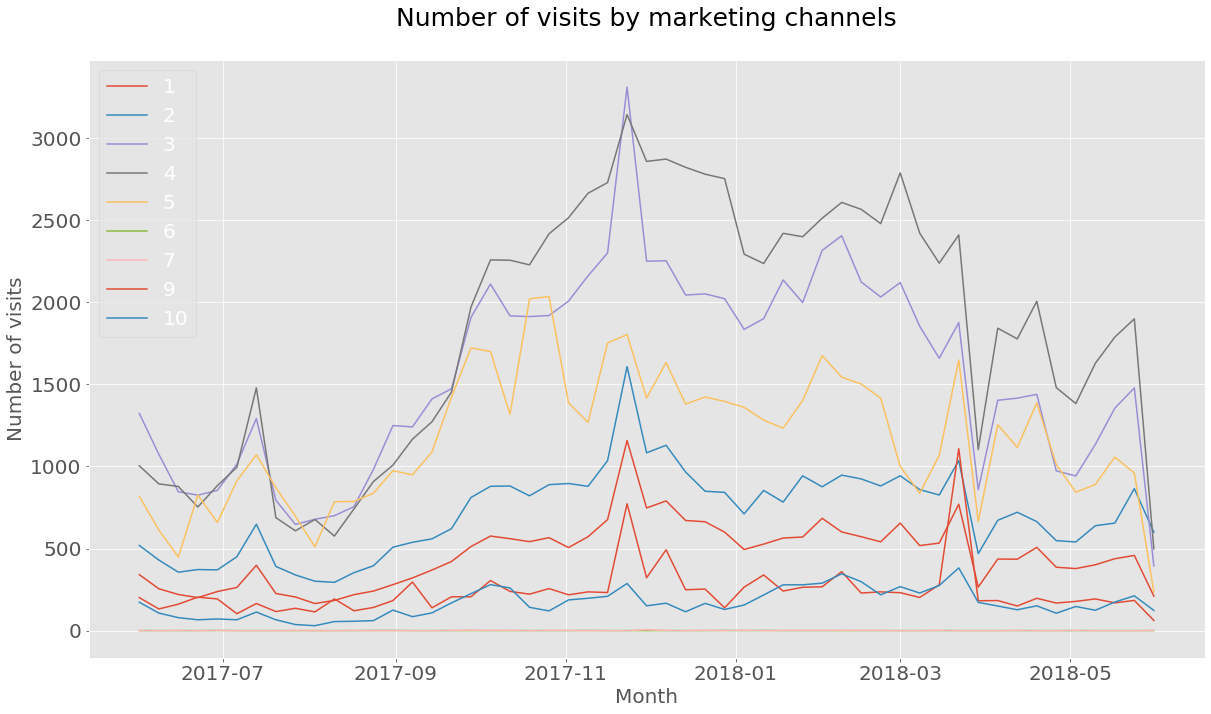

In [13]:
plt.style.use('ggplot')
wau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_week', values='uid', 
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

plt.figure(figsize=(20,11))
plt.grid(True)
plt.title('Number of visits by marketing channels' + '\n', 
          fontsize = 25, color='black')
plt.plot(wau_pivot)
plt.legend(wau_pivot.columns, loc=0, prop={'size': 20})
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of visits', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<font face='Liberation serif' size=4>**Итоги:**</font>

Самые прибыльные месяцы - ноябрь и декабрь;
Наибольшое количество визитов с 3 и 4 маркетингового каналов;
Количество постоянных клиентов не так много, относительно общих пользователей

<font face='Liberation serif' size=4>**Сколько сеансов в день?**</font>

In [14]:
# расчет количества сеансов на пользователя
def count_sessions_per_day(df):
    '''Calculates the number of sessions per day, 
    displays 'describe'
    '''
    print('Statistics on the number of sessions per day:')
    display(round(df.groupby(['dt_start_of_session_year', 
                              'dt_start_of_session_day']).agg({'uid':'count'})\
                  .describe()))
    print('An average users have {:.2f} sessions per day'.\
          format(df.groupby(['dt_start_of_session_year', 
                             'dt_start_of_session_day'])['uid'].count().mean() / 
                df.groupby(['dt_start_of_session_year', 
                            'dt_start_of_session_day'])['uid'].nunique().mean()))

In [15]:
for device in ['desktop', 'touch']:
    print('\033[1m' + device + '\033[0m')
    count_sessions_per_day(df_visits.query('device_cat==@device'))

desktop
Statistics on the number of sessions per day:


,uid
count,364.000
mean,721.000
std,322.000
min,1.000
25%,457.000
50%,711.000
75%,962.000
max,3152.000


An average users have 1.09 sessions per day
touch
Statistics on the number of sessions per day:


,uid
count,363.000
mean,267.000
std,111.000
min,47.000
25%,181.000
50%,278.000
75%,337.000
max,890.000


An average users have 1.05 sessions per day


В среднем у пользователей одна сессия в день. Для настольной версии это число немного выше.

<font face='Liberation serif' size=4>**Как долго длится типичный сеанс?**</font>

In [16]:
# Когда мы впервые отобразили функцию описания, было ясно, что было несколько сеансов
# длиной 19 секунд. Это не кажется правдоподобным, поэтому округлим их до 1 минуты.
df_visits['dt_start_of_session'] = pd.to_datetime(df_visits['dt_start_of_session'])
df_visits['dt_start_of_session'] = df_visits['dt_start_of_session'].dt.ceil('1T')
df_visits['dt_end_of_session'] = df_visits['dt_end_of_session'].dt.ceil('1T')

# для начала проверим на предмет ошибок в данных и посмотрим, есть ли у нас отрицательные значения
df_visits['session_length_seconds_total'] = (df_visits['dt_end_of_session'] - 
                                             df_visits['dt_start_of_session']).\
dt.total_seconds()
display(df_visits['session_length_seconds_total'].describe())

count   359400.000
mean       643.125
std        997.068
min      -2760.000
25%        120.000
50%        300.000
75%        840.000
max      42660.000
Name: session_length_seconds_total, dtype: float64

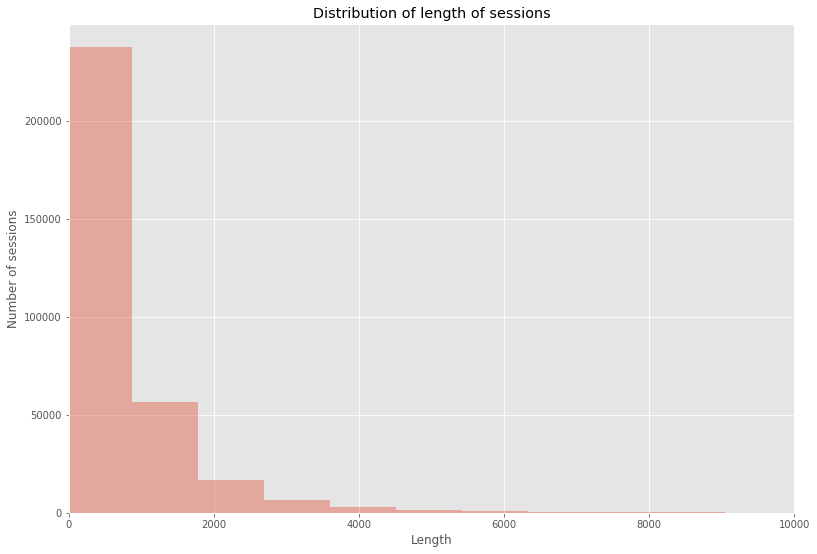

2

0

Mode is 60 seconds
count   323606.000
mean       714.290
std       1026.282
min         60.000
25%        120.000
50%        360.000
75%        900.000
max      42660.000
Name: session_length_seconds_total, dtype: float64


In [17]:
# В данных присутствую нули, они вероятнее всего - ошибка, лучше всего нам исбавиться от них
session_length_no_zeros = df_visits.query('session_length_seconds_total != 0')
plt.figure(figsize=(13,9))
sns.distplot(session_length_no_zeros['session_length_seconds_total'], kde=False)
plt.xlim(0, 10000)
plt.title('Distribution of length of sessions', c='black')
plt.xlabel('Length')
plt.ylabel('Number of sessions')
plt.show()

# Более того, есть -2760. Проверим на отрицательные значения
display(session_length_no_zeros['session_length_seconds_total']\
            [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# у нас есть два отрицательных значения. Давайте использовать abs ()
session_length_no_zeros['session_length_seconds_total'] = \
session_length_no_zeros['session_length_seconds_total'].abs()
display(session_length_no_zeros['session_length_seconds_total']\
        [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# распределение кажется далеким от нормального, следовательно, репрезентативная выборка
# центральной тенденции будет либо медиана, либо мода

print('Mode is', int(
    session_length_no_zeros['session_length_seconds_total'].\
    mode().round(2)), 'seconds')
print(session_length_no_zeros['session_length_seconds_total'].describe())

<font face='Liberation serif' size=4>**Воводы:**</font>

Большинство людей проводят 60 секунд, но так ли это на самом деле? Возможно, что более репрезентативной для центральной тенденции распределения будет медиана, которая составляет 6 минут. 

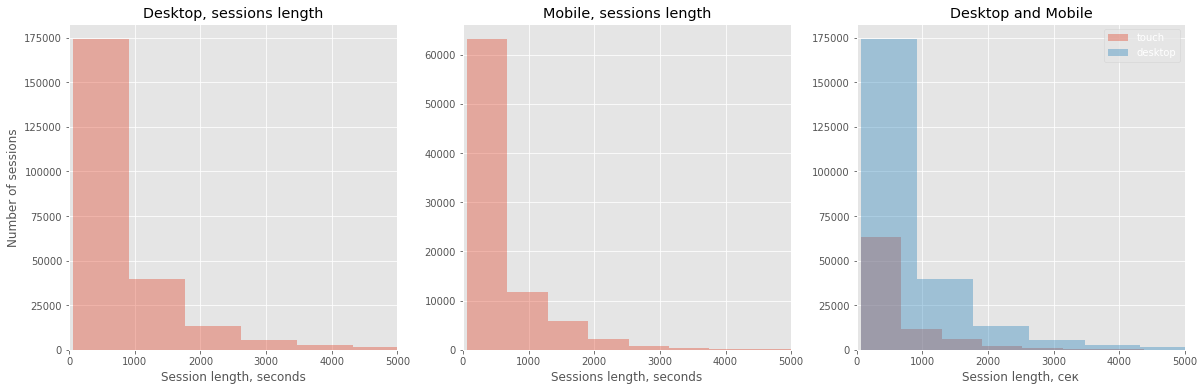

In [18]:
# визуализация распределения продолжительности сеанса для категорий деления
session_length_no_zeros_desktop = session_length_no_zeros.query(
    'device_cat =="desktop"')
session_length_no_zeros_touch = session_length_no_zeros.query(
    'device_cat =="touch"')
names = ['Desktop, sessions length', 'Mobile, sessions length',
    'Desktop and Mobile']

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(6)

sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[0])
ax[0].set_xlim(0,5000)
ax[0].set_title(names[0], c='black')
ax[0].set_xlabel('Session length, seconds')
ax[0].set_ylabel('Number of sessions')

sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'], 
            kde=False, ax=ax[1])
ax[1].set_xlabel('Sessions length, seconds')
ax[1].set_title(names[1], c='black')
ax[1].set_xlim(0,5000)


sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'],
            kde=False, ax=ax[2], label='touch')
sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[2], label='desktop')
ax[2].set_title(names[2], c='black')
ax[2].set_xlabel('Session length, сек')
ax[2].set_xlim(0,5000)
plt.legend()
plt.show()

Мы рассчитали и моду, и медиану. Однако мы все еще не можем сказать, какая мера центральной тенденции более репрезентативна для нас. Скорее всего, в данных есть ошибка, из-за которой многие сеансы помечены малой продолжительностью - тогда нам подходит медиана. А здравый смысл подсказывает, что сложно успеть что-то увидеть за минуту, а тем более купить на сайте.

<font face='Liberation serif' size=4>**Как часто люди возвращаются? Рассчитаем Retention Rate.**</font>

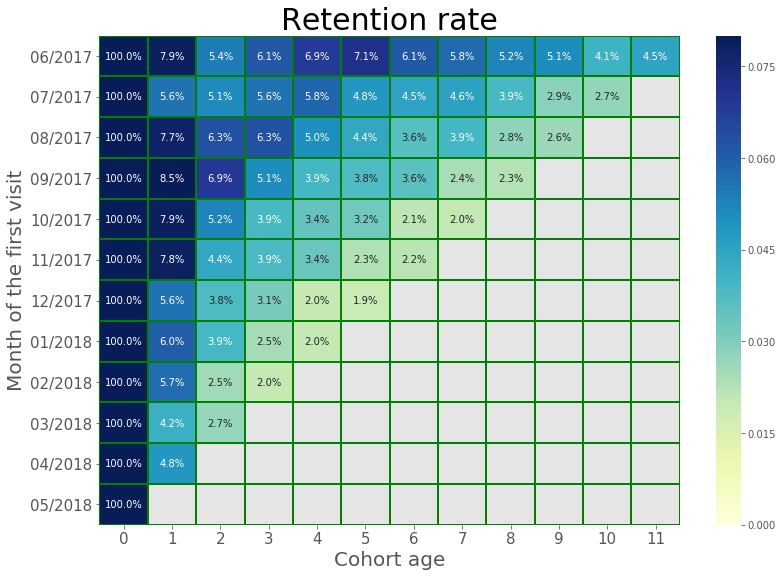

In [19]:
# расчёт retention rate

def get_month(x): return dt.datetime(x.year, x.month, 1)
df_visits['visit_month'] = df_visits['dt_start_of_session'].apply(get_month)
grouping = df_visits.groupby('uid')['visit_month']
df_visits['cohort_month'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def count_retention(df):
    visit_year, visit_month, _ = get_date_int(df, 'visit_month')
    cohort_year, cohort_month, _ = get_date_int(df, 'cohort_month')
    year_diff = visit_year - cohort_year
    month_diff = visit_month - cohort_month
    df['cohort_index'] = year_diff * 12 + month_diff    
    grouping = df.groupby(['cohort_month', 'cohort_index'])
    cohort_data = grouping['uid'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot_table(index='cohort_month', 
                                            columns='cohort_index', values='uid')
    cohort_sizes = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.round(4) * 100
    retention.index = retention.index.strftime("%m/%Y")
    return retention

# визуализируем с помощью хит мапа  
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

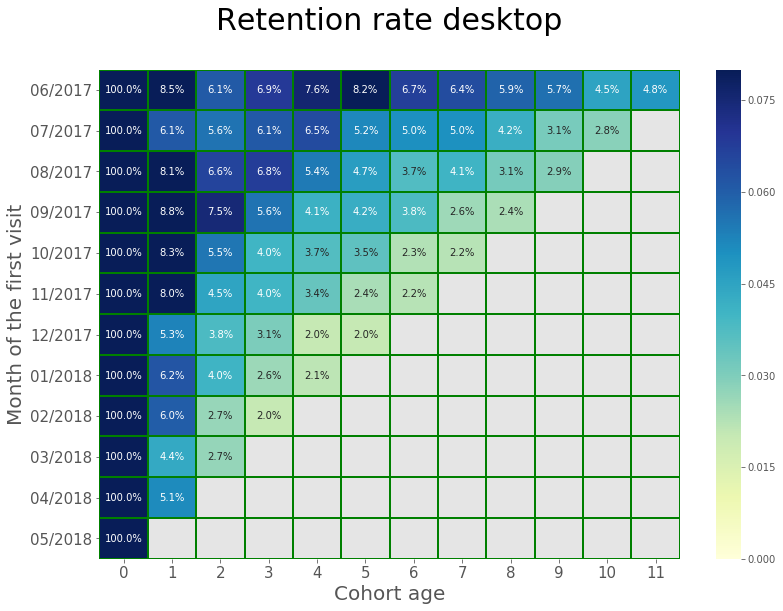

In [20]:
# рассчитаем RR для desktop
df_visits_desktop = df_visits.query('device_cat == "desktop"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_desktop), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate desktop' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

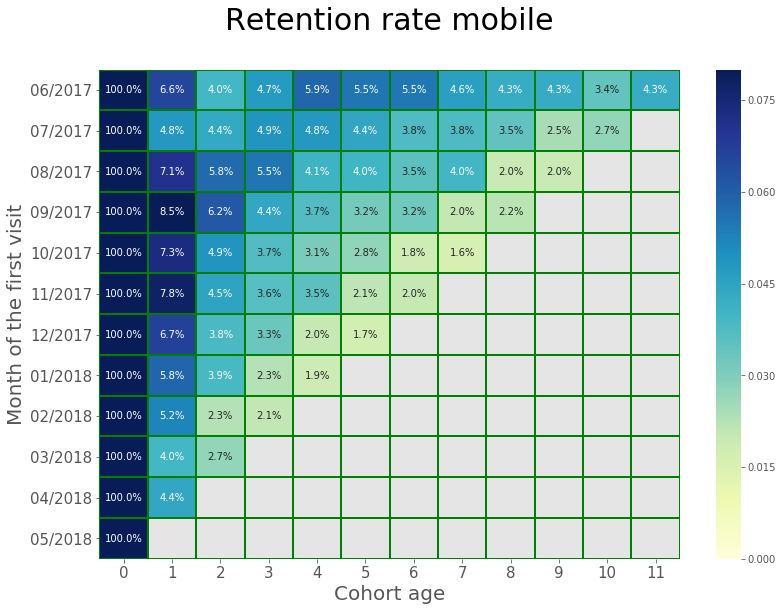

In [21]:
df_visits_touch = df_visits.query('device_cat == "touch"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_touch), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate mobile' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

Понятно, что показатель RR у компьютеров выше, чем у мобильной версии. Посчитаем точное число, на которое он выше.

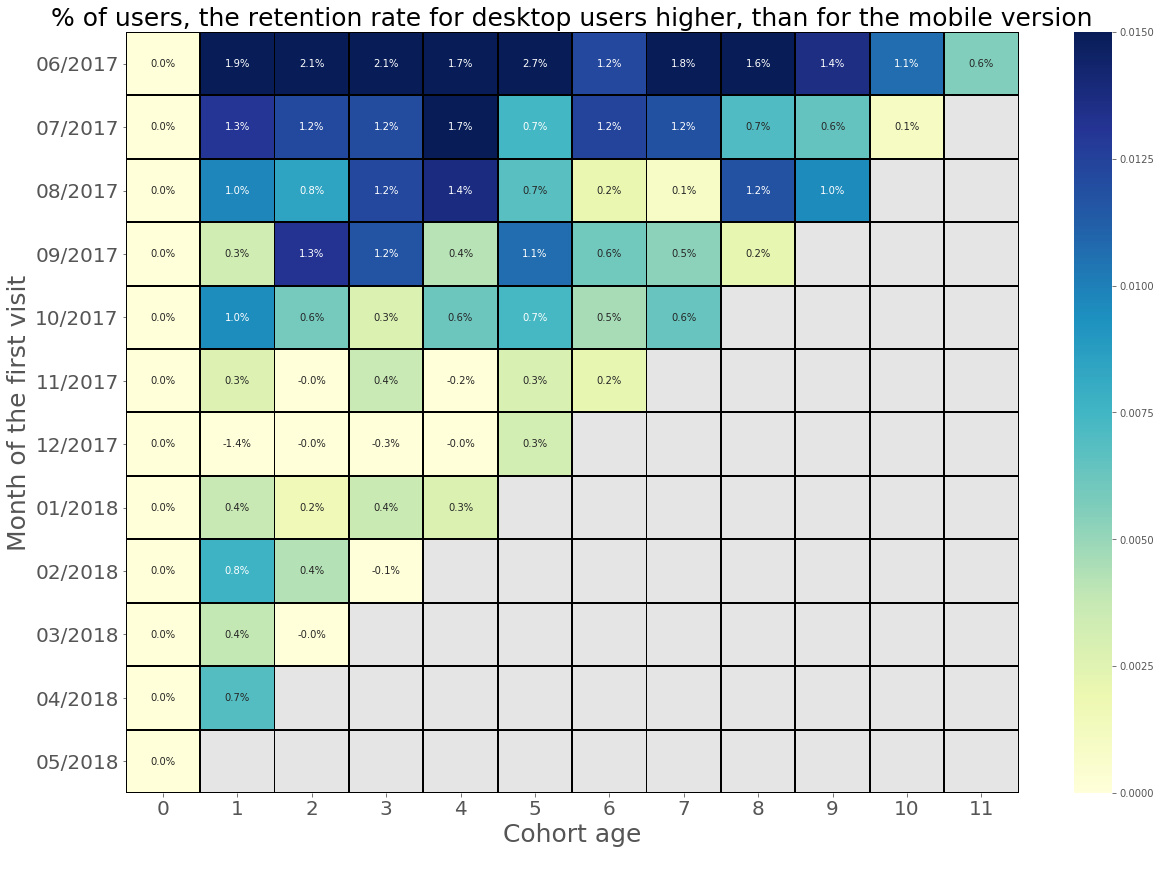

In [22]:
diff_between_retentions = count_retention(df_visits_desktop) - \
count_retention(df_visits_touch)
plt.figure(figsize=(20,14))
sns.heatmap(diff_between_retentions, annot=True, fmt='.1%', linewidth=1, 
            linecolor='black', cmap='YlGnBu', vmin=0, vmax=0.015)
plt.title('% of users, the retention rate for desktop users higher, than \
for the mobile version', 
          fontsize=25, c='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=0)
plt.xlabel('Cohort age'+ '\n', fontsize=25)
plt.ylabel('Month of the first visit', fontsize=25)
plt.show()

средний уровень удержания составляет 4,6%

<font face='Liberation serif' size=4>**Когда люди начинают покупать?**</font>

In [23]:
# посчитаем количество дней от первого посещения до первой покупки
first_session = df_visits.groupby('uid')['dt_start_of_session'].min()
first_session.name = 'first_session'
df_visits = df_visits.merge(first_session, on='uid')
first_visit = df_visits[['uid', 'first_session', 'device_cat', 
                         'commercial_source_id']].reset_index()
first_visit = first_visit.sort_values(by='first_session')
first_visit = first_visit.groupby('uid')[['first_session', 'device_cat', 
                                          'commercial_source_id']].\
first().reset_index()
first_purchase = df_orders.groupby('uid')['dt_of_order'].min().reset_index()
time_to_first_purchase = first_visit.merge(first_purchase, on='uid', how='right')

time_to_first_purchase['time_to_first_purchase'] = pd.to_timedelta(
    (time_to_first_purchase['dt_of_order'] - \
     time_to_first_purchase['first_session']).\
    dt.days, unit='d')/np.timedelta64(1, 'D')

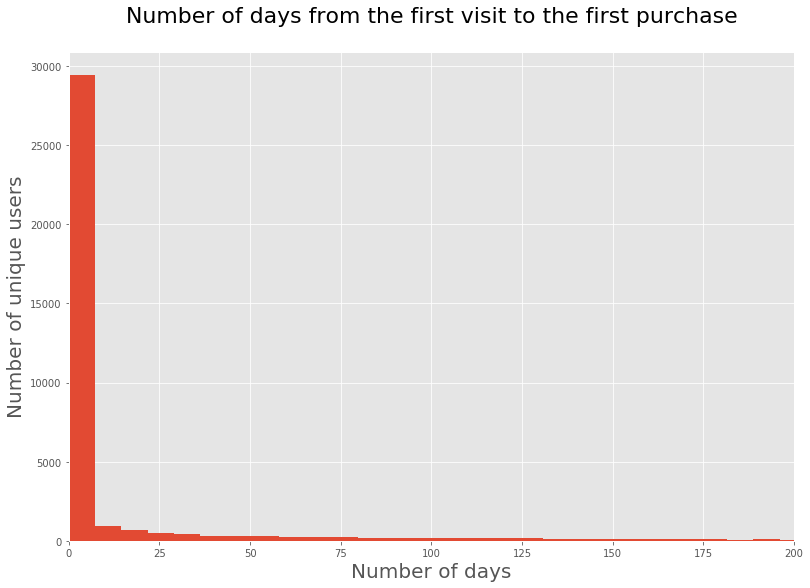

Mode for desktop and mobile is 0
Mode for desktop is 0
Mode for mobile is 0


In [24]:
plt.figure(figsize=(13,9))
time_to_first_purchase['time_to_first_purchase'].hist(bins=50)
plt.xlim(0,200)
plt.xlabel('Number of days',
           fontsize=20)
plt.ylabel('Number of unique users', fontsize=20)
plt.title('Number of days from the first visit to the first purchase' + '\n', 
          fontsize=22, color='black')
plt.show()
# посмотрим, какая мода у этой метрики по категории устройств
print('Mode for desktop and mobile is', 
      int(time_to_first_purchase['time_to_first_purchase'].mode()))
time_to_first_purchase_desktop = time_to_first_purchase.query(
    'device_cat == "desktop"')
print('Mode for desktop is',
      int(time_to_first_purchase_desktop['time_to_first_purchase'].mode()))
time_to_first_purchase_touch = time_to_first_purchase.query(
    'device_cat == "touch"')
print('Mode for mobile is',
      int(time_to_first_purchase_touch['time_to_first_purchase'].mode()))

На графике показано, что большинство пользователей совершают покупки в первый день посещения. Есть способ это проверить. Нам нужно подсчитать совокупную сумму всех сеансов и увидеть процент пользователей, у которых есть только один сеанс. Если это большинство, то нам не нужно подозревать, что mode равен 0.

In [25]:
df_visits['num_of_session'] = df_visits.sort_values(
    ['uid','dt_start_of_session'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1
df_visits.sort_values(by=['uid', 'num_of_session'])
df_visits['num_of_session'].value_counts(normalize=True).head(10)

1    0.635
2    0.145
3    0.059
4    0.031
5    0.019
6    0.012
7    0.009
8    0.006
9    0.005
10   0.004
Name: num_of_session, dtype: float64

Распределение суммы количества сеансов по пользователям предполагает, что 63,5 процента пользователей оплачивают наш продукт только за одно посещение. Соответственно, люди в среднем начинают покупать в первый же день на сайте.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Отличная проверка👌</div> <br>

<font face='Liberation serif' size=4>**Сколько покупок в месяц?**</font>

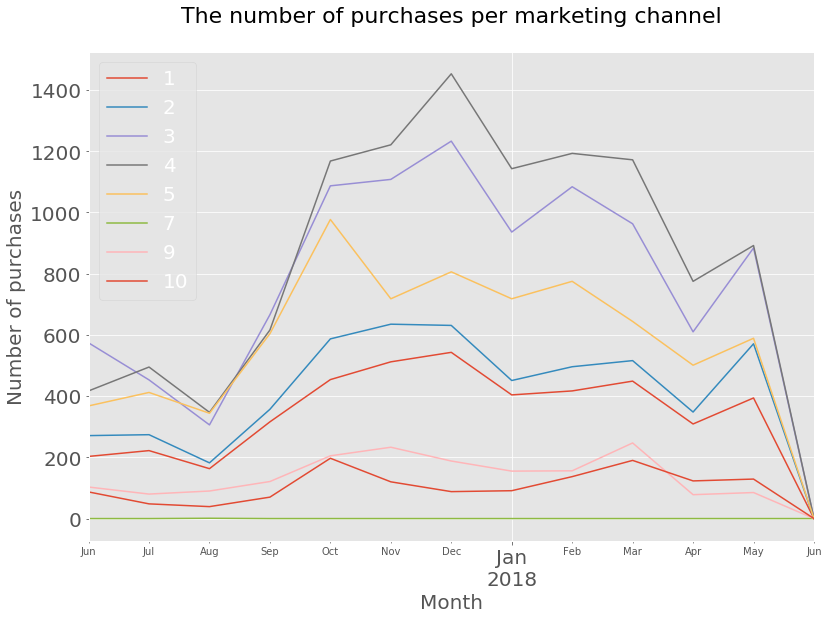

In [26]:
# подсчет количества покупок по маркетинговому каналу
first_source = df_visits.groupby(['uid'])[['commercial_source_id', 
                                           'device_cat']].first()
purchases = df_orders.merge(first_source, on='uid',
                        how='left')

purchases['order_month'] = purchases['dt_of_order'].\
astype('datetime64[M]')
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='commercial_source_id', 
                                 aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13,9))
plt.title('The number of purchases per marketing channel' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of purchases', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

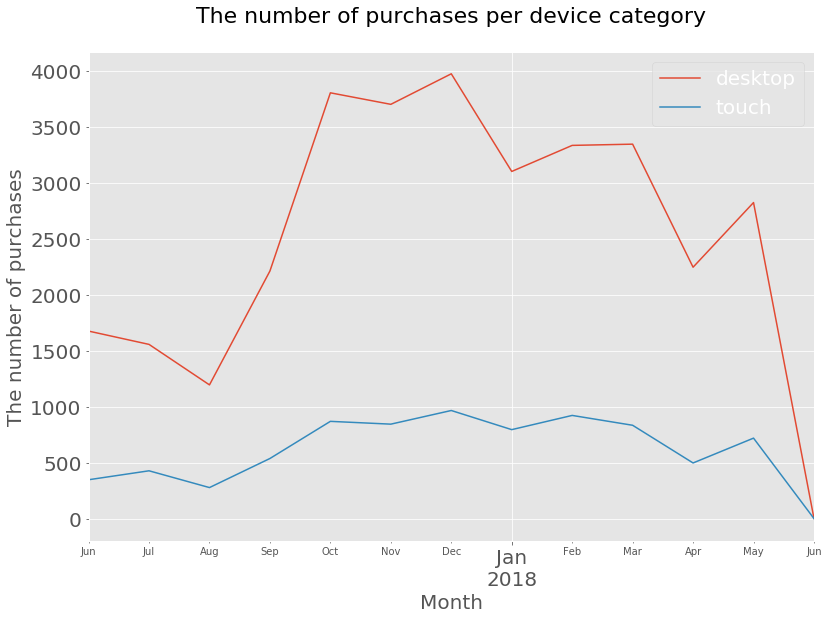

The average number of purchases is 3878
The average number of purchases for desktop is 3146
The average number of purchases for mobile is 792


In [27]:
# покупки на категорию устройств
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='device_cat', aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13, 9))
plt.title('The number of purchases per device category' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('The number of purchases', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

# среднее количество покупок в месяц
mean_number_of_purchases_by_month = purchases.groupby(
    'order_month')['uid'].count().mean()

# среднее количество покупок на категорию устройств
number_of_purchases_by_month_desktop = purchases.query(
    'device_cat == "desktop"')
mean_number_of_purchases_by_month_desktop = \
number_of_purchases_by_month_desktop.groupby('order_month')['uid'].\
count().mean()
number_of_purchases_by_month_touch = purchases.query(
    'device_cat == "touch"')
mean_number_of_purchases_by_month_touch = number_of_purchases_by_month_touch.\
groupby('order_month')['uid'].count().mean()
print('The average number of purchases is', int(
    mean_number_of_purchases_by_month))
print('The average number of purchases for desktop is', int(
    mean_number_of_purchases_by_month_desktop))
print('The average number of purchases for mobile is', int(
    mean_number_of_purchases_by_month_touch))

In [28]:
# подсчет количества покупок на пользователя

# группировка по uid
grouping_orders = purchases.groupby('uid')['order_month']

# месяц первой покупки
purchases['cohort_month'] = grouping_orders.transform('min')
visit_year, visit_month, _ = get_date_int(purchases, 'order_month')
cohort_year, cohort_month, _ = get_date_int(purchases, 'cohort_month')
year_diff_orders = visit_year - cohort_year
month_diff_orders = visit_month - cohort_month
purchases['cohort_index'] = year_diff_orders * 12 + month_diff_orders
grouping_orders = purchases.groupby(['cohort_month', 'cohort_index'])
cohort_data_orders = grouping_orders['uid'].apply(pd.Series.nunique)
cohort_data_orders = cohort_data_orders.reset_index()
cohort_counts_orders = cohort_data_orders.pivot_table(index='cohort_month', 
                                                      columns='cohort_index', 
                                                     values='uid')
users_by_month = purchases.groupby('order_month').agg({'uid':'nunique'})
users_by_month.name = 'users_by_month'
purchases_by_month = purchases.groupby('order_month').agg({'uid':'count'})
purchases_by_month.name = 'purchases_by_month'
purchases_by_month_mean = purchases_by_month / users_by_month
purchases_by_month_mean.mean()
print('Average number of purchases per user is', float(purchases_by_month_mean.\
                                                     mean().round(2)))

Average number of purchases per user is 1.21


Средний пользователь совершает 1,2 покупки.
Доля покупок на компьютере / мобильном устройстве примерно осталась на уровне доли посещений.

<font face='Liberation serif' size=4>**Какой средний чек?**</font>

The average receipt is 4.999646930477041 thousand roubles


4.999646930477041

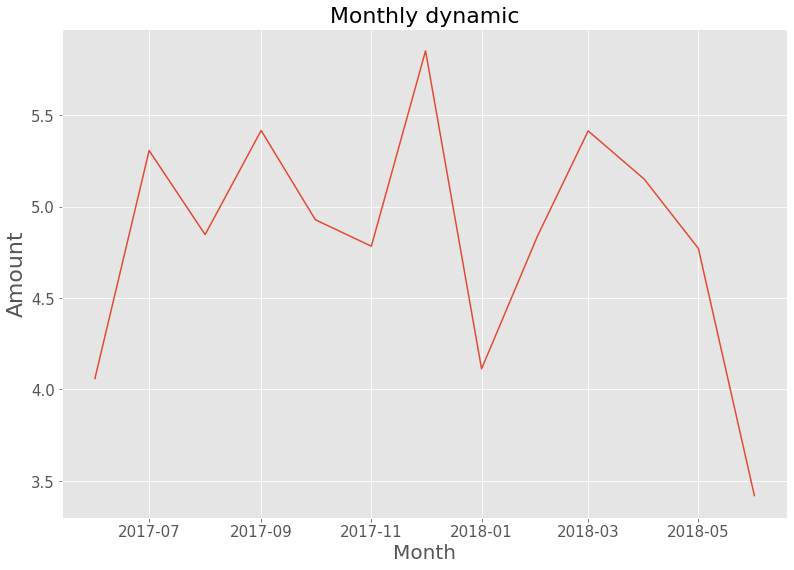

In [29]:
# средний чек
df_orders['month_of_order'] = df_orders['dt_of_order'].astype('datetime64[M]')
print('The average receipt is', float(df_orders['revenue'].mean()), 'thousand roubles')
plt.figure(figsize=(13, 9))
plt.plot(df_orders.pivot_table(index='month_of_order', values='revenue', 
                               aggfunc='mean'))
plt.title('Monthly dynamic', fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Amount', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
df_orders['revenue'].mean()

Средний чек - 5 тысяч рублей. Наблюдая за средним чеком, можно заметить некоторую сезонность. В декабре наблюдается значительный рост (возможно, люди покупают подарки), в январе резко падает, а в марте все возвращается на круги своя.

<font face='Liberation serif' size=4>**Какой доход приносят нам клиенты? (LTV)**</font>

Заранее обговорим, что маржи не было представленно, так что, дабы не искажать данные мы возьмём маржу за 1

  first_order_month  n_buyers order_month  revenue       gp  age   ltv
0        2017-06-01      2023  2017-06-01 9557.490 9557.490    0 4.724


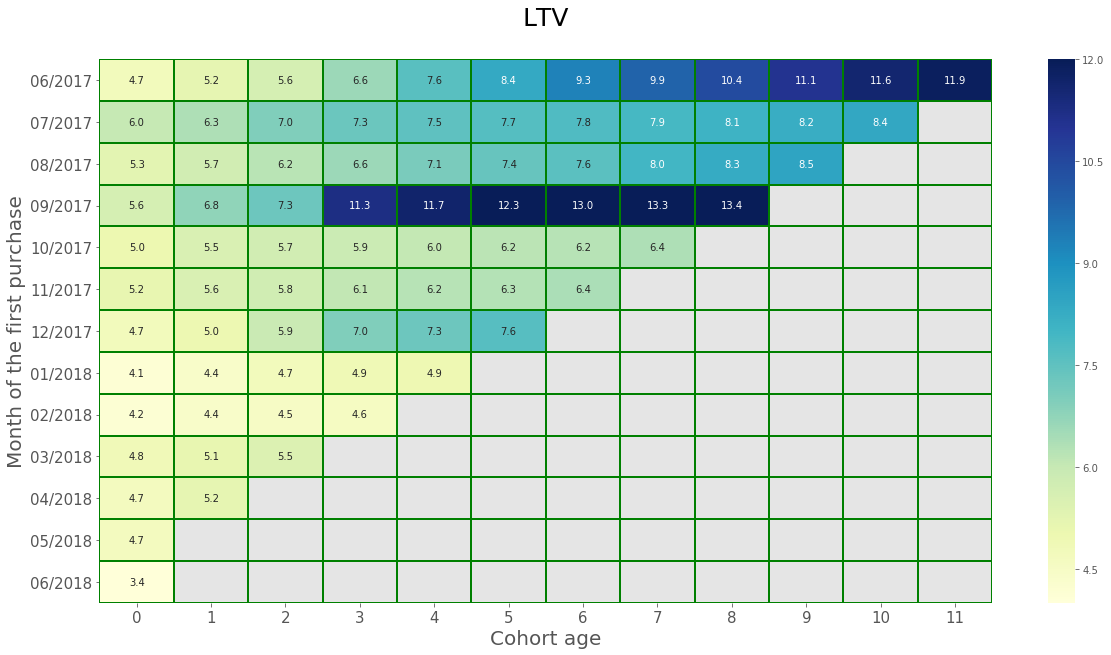

Average LTV for the first 6 months is 7.97 thousand


In [30]:
# посчитаем LTV
df_orders_ltv = df_orders.copy()
def count_ltv(df):
    df['order_month'] = df['dt_of_order'].astype('datetime64[M]')
    first_order = df.groupby('uid').agg({'order_month':'min'}).\
    reset_index()
    first_order.columns = ['uid', 'first_order_month']
    cohort_sizes = first_order.groupby('first_order_month').\
    agg({'uid':'nunique'}).\
    reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    df_new = pd.merge(df,first_order, on='uid')
    cohorts = df_new.groupby(['first_order_month', 'order_month']).\
    agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_order_month']) / \
    np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    return report

report_ltv = count_ltv(df_orders)  
print(report_ltv.head(1)) 


output = report_ltv.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').round(4)
output.fillna('')
output = output.cumsum(axis=1)
output.index = output.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output, annot=True, fmt = '.1f', linewidths=1, linecolor='green', 
            cmap="YlGnBu", vmin=4, vmax=12)
plt.ylabel('Month of the first purchase', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('LTV' + '\n', fontsize=25, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# примим за период жизни клиента 6 месяцев и рассчитаем средний ltv за это время
final_result = report_ltv.pivot_table(index='first_order_month', columns='age',
                                  values='ltv', aggfunc='mean')
m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
print('Average LTV for the first 6 months is', m6_cum_ltv.round(2), 'thousand')
#report_sources = count_ltv(orders_sources)
#print()

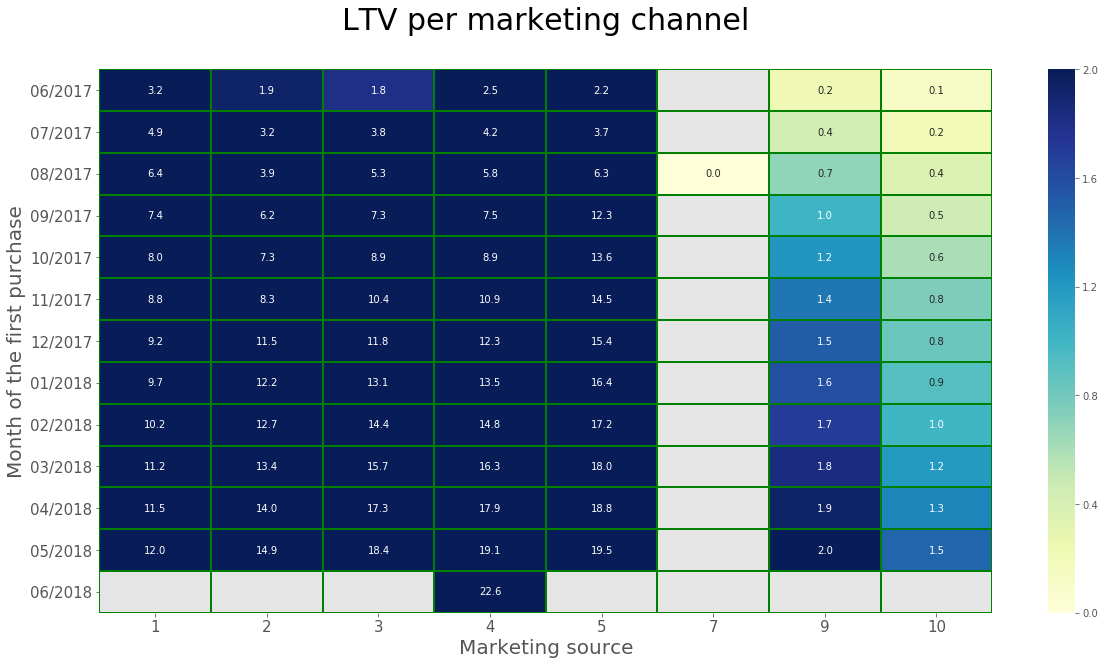

In [31]:

# Рассчитаем LTV для маркетинговых каналов
visits_sources = df_visits.sort_values(by = ['uid', 'dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first', 
                                            'visit_month': 'first'})
#visits_sources = df_visits.groupby('uid')['commercial_source_id'].first().\
#reset_index()
#df_visits
orders_sources = df_orders.merge(visits_sources, how = 'left', on = 'uid')
orders_sources
orders_sources['order_month'] = orders_sources['dt_of_order'].\
astype('datetime64[M]')
first_order_source = orders_sources.groupby('uid').agg({'order_month': 'min'}).\
reset_index()
first_order_source.columns = ['uid', 'first_order_month']
orders_sources
first_order_source
cohort_sizes = first_order_source.groupby('first_order_month').\
agg({'uid':'nunique'}).reset_index()

cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_source_new = pd.merge(orders_sources,first_order_source, on='uid')
cohorts_orders = orders_source_new.groupby(['first_order_month','order_month', 
                                            'commercial_source_id']).\
agg({'revenue': 'sum'}).reset_index()
report_source = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
margin_rate = 1
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']


# визуализируем полученную таблицу 
output_source = report_source.pivot_table(index = 'first_order_month', 
                                          columns = 'commercial_source_id', 
                                          values = 'ltv', aggfunc = 'sum').round(4).cumsum(axis=0)
output_source.fillna('')
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, annot=True, fmt = '.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin = 0, vmax = 2)
plt.ylabel('Month of the first purchase', fontsize = 20)
plt.xlabel('Marketing source', fontsize = 20)
plt.title('LTV per marketing channel' + '\n', fontsize = 30, c='black')
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()


<a class="anchor" id="21-bullet">

In [32]:
# размеры когорт
cohort_size = df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False)\
    .agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .groupby(['first_order_month', "commercial_source_id"], as_index=False).agg({'uid': 'nunique'})
cohort_size

,first_order_month,commercial_source_id,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


In [33]:
# LTV для первого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==1")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,7.256,9.440,11.648,15.407,19.677,21.726,24.307,26.829,29.104,30.769,31.974,33.644
2017-07-01,7.292,8.388,13.742,15.249,16.127,17.027,17.474,18.120,18.977,19.963,20.891,nan
2017-08-01,7.493,8.691,9.701,10.666,11.705,12.371,13.052,15.709,17.902,18.681,nan,nan
2017-09-01,6.015,7.817,8.376,9.301,9.339,9.435,9.520,9.827,10.417,nan,nan,nan
2017-10-01,6.019,7.074,7.319,7.707,7.770,7.878,8.062,8.383,nan,nan,nan,nan
2017-11-01,7.391,7.965,8.928,9.822,9.985,10.091,10.172,nan,nan,nan,nan,nan
2017-12-01,4.584,4.895,5.184,5.430,5.456,5.552,nan,nan,nan,nan,nan,nan
2018-01-01,5.769,5.859,6.004,6.977,7.027,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.687,5.686,5.754,6.123,nan,nan,nan,nan,nan,nan,nan,nan


In [34]:
# LTV для второго источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==2")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.441,4.933,5.205,7.130,8.796,9.715,11.318,12.800,14.135,14.869,16.227,16.661
2017-07-01,8.430,9.195,9.255,9.576,10.009,10.195,10.494,10.631,10.742,10.971,11.334,nan
2017-08-01,5.739,6.675,6.853,7.104,7.619,7.682,7.804,8.197,8.230,8.315,nan,nan
2017-09-01,8.282,16.411,18.773,19.696,21.104,22.079,25.397,26.151,26.703,nan,nan,nan
2017-10-01,7.676,10.132,10.793,11.333,11.889,12.156,12.255,12.508,nan,nan,nan,nan
2017-11-01,6.989,7.898,8.336,9.119,9.432,9.575,9.720,nan,nan,nan,nan,nan
2017-12-01,8.809,10.351,19.682,30.783,33.828,37.038,nan,nan,nan,nan,nan,nan
2018-01-01,4.343,5.433,7.171,7.415,7.744,nan,nan,nan,nan,nan,nan,nan
2018-02-01,5.417,6.064,6.388,6.643,nan,nan,nan,nan,nan,nan,nan,nan


<hr style="border: 2px solid red;" />

In [35]:
# LTV для третьего источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==3")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.396,4.508,4.695,5.006,5.192,5.385,5.513,5.542,5.592,5.645,5.674,5.706
2017-07-01,6.105,6.368,6.492,6.886,6.926,6.997,7.033,7.165,7.249,7.290,7.346,nan
2017-08-01,5.079,5.233,5.521,5.628,5.790,5.840,5.904,5.997,6.076,6.136,nan,nan
2017-09-01,5.563,5.811,6.135,6.223,6.447,6.566,6.693,6.767,6.888,nan,nan,nan
2017-10-01,4.787,5.244,5.363,5.425,5.533,5.629,5.647,5.720,nan,nan,nan,nan
2017-11-01,4.532,4.667,4.751,4.869,4.925,4.957,4.990,nan,nan,nan,nan,nan
2017-12-01,4.179,4.311,4.453,4.579,4.678,4.739,nan,nan,nan,nan,nan,nan
2018-01-01,4.114,4.296,4.429,4.508,4.561,nan,nan,nan,nan,nan,nan,nan
2018-02-01,3.788,4.097,4.186,4.247,nan,nan,nan,nan,nan,nan,nan,nan


In [36]:
# LTV для четвёртого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==4")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.745,4.786,4.957,5.416,6.564,8.053,9.483,9.716,9.932,10.735,12.004,12.089
2017-07-01,5.545,5.604,5.684,5.844,5.900,5.963,6.065,6.110,6.197,6.258,6.280,nan
2017-08-01,5.065,5.234,5.365,5.632,5.778,5.987,6.070,6.259,6.352,6.475,nan,nan
2017-09-01,4.767,5.247,5.561,5.849,5.899,6.136,7.391,7.656,7.708,nan,nan,nan
2017-10-01,4.368,4.514,4.665,4.777,4.896,4.988,5.076,5.141,nan,nan,nan,nan
2017-11-01,5.144,5.791,5.892,6.297,6.492,6.535,6.756,nan,nan,nan,nan,nan
2017-12-01,4.172,4.261,4.353,4.439,4.479,4.564,nan,nan,nan,nan,nan,nan
2018-01-01,3.782,3.902,3.985,4.058,4.088,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.093,4.204,4.239,4.257,nan,nan,nan,nan,nan,nan,nan,nan


In [37]:
# LTV для пятого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==5")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.945,5.848,6.297,7.170,7.833,8.131,9.036,9.623,10.182,11.127,11.283,11.400
2017-07-01,5.287,5.606,6.061,6.214,6.311,6.419,6.445,6.556,6.648,6.705,6.780,nan
2017-08-01,5.050,5.802,6.634,7.344,8.424,9.019,9.404,9.650,9.888,10.122,nan,nan
2017-09-01,6.196,6.379,6.710,22.878,23.651,25.670,25.950,26.150,26.173,nan,nan,nan
2017-10-01,5.091,5.314,5.434,5.557,5.670,5.767,5.911,6.037,nan,nan,nan,nan
2017-11-01,4.560,4.748,4.865,4.921,5.058,5.098,5.206,nan,nan,nan,nan,nan
2017-12-01,5.007,5.142,5.232,5.287,5.306,5.314,nan,nan,nan,nan,nan,nan
2018-01-01,4.352,4.870,5.255,5.286,5.314,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.322,4.414,4.460,4.470,nan,nan,nan,nan,nan,nan,nan,nan


In [38]:
# LTV для шестого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==6")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

first_order_month


In [39]:
# LTV для седьмого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==7")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0
first_order_month,
2017-08-01,1.220


In [40]:
# LTV для второго источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==8")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

first_order_month


In [41]:
# LTV для девятого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==9")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10
first_order_month,,,,,,,,,,,
2017-06-01,3.569,3.641,4.229,4.836,5.103,5.546,6.078,6.202,6.740,6.863,6.943
2017-07-01,4.469,4.627,5.255,5.740,6.108,6.170,6.455,6.514,6.944,6.968,7.042
2017-08-01,4.075,4.273,4.914,5.145,5.199,5.267,5.403,5.694,5.775,5.925,nan
2017-09-01,4.297,5.320,5.949,6.752,7.351,7.479,8.095,8.760,9.669,nan,nan
2017-10-01,5.064,5.604,6.042,6.159,6.447,6.989,7.006,7.025,nan,nan,nan
2017-11-01,3.739,3.873,4.037,4.324,4.474,4.505,4.526,nan,nan,nan,nan
2017-12-01,3.826,4.140,4.313,4.579,4.603,4.750,nan,nan,nan,nan,nan
2018-01-01,2.834,3.052,3.254,3.291,3.314,nan,nan,nan,nan,nan,nan
2018-02-01,4.801,4.974,5.050,nan,nan,nan,nan,nan,nan,nan,nan


In [42]:
# LTV для десятого источника по когортам
df_orders.merge(df_visits.sort_values(by = ['dt_start_of_session']).\
                        groupby('uid').agg({'commercial_source_id': 'first'}), on='uid')\
    .merge(df_orders.groupby('uid', as_index=False).agg({'order_month': 'min'}).rename(columns={'order_month': 'first_order_month'}), on='uid')\
    .assign(age=lambda row: ((row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')).round().astype(int))\
    .groupby(['first_order_month', "commercial_source_id", 'age'], as_index=False).agg({'revenue': 'sum'})\
    .merge(cohort_size, on=['first_order_month', "commercial_source_id"])\
    .assign(ltv=lambda row: row['revenue'] / row['uid'])\
    .query("commercial_source_id==10")\
    .pivot_table(index="first_order_month", columns='age', values='ltv').cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9
first_order_month,,,,,,,,,,
2017-06-01,2.414,2.531,nan,nan,nan,nan,nan,nan,2.540,nan
2017-07-01,3.461,3.493,nan,3.642,nan,nan,nan,nan,3.649,nan
2017-08-01,4.997,5.109,5.440,nan,nan,nan,nan,5.564,nan,5.654
2017-09-01,2.234,2.299,2.381,2.572,2.600,nan,nan,2.610,2.635,nan
2017-10-01,2.619,2.702,2.712,2.729,2.768,2.777,2.797,2.849,nan,nan
2017-11-01,4.622,4.674,4.689,4.874,4.979,5.029,5.084,nan,nan,nan
2017-12-01,3.791,3.928,nan,nan,nan,3.985,nan,nan,nan,nan
2018-01-01,3.099,3.114,3.184,nan,nan,nan,nan,nan,nan,nan
2018-02-01,2.474,2.590,2.594,nan,nan,nan,nan,nan,nan,nan


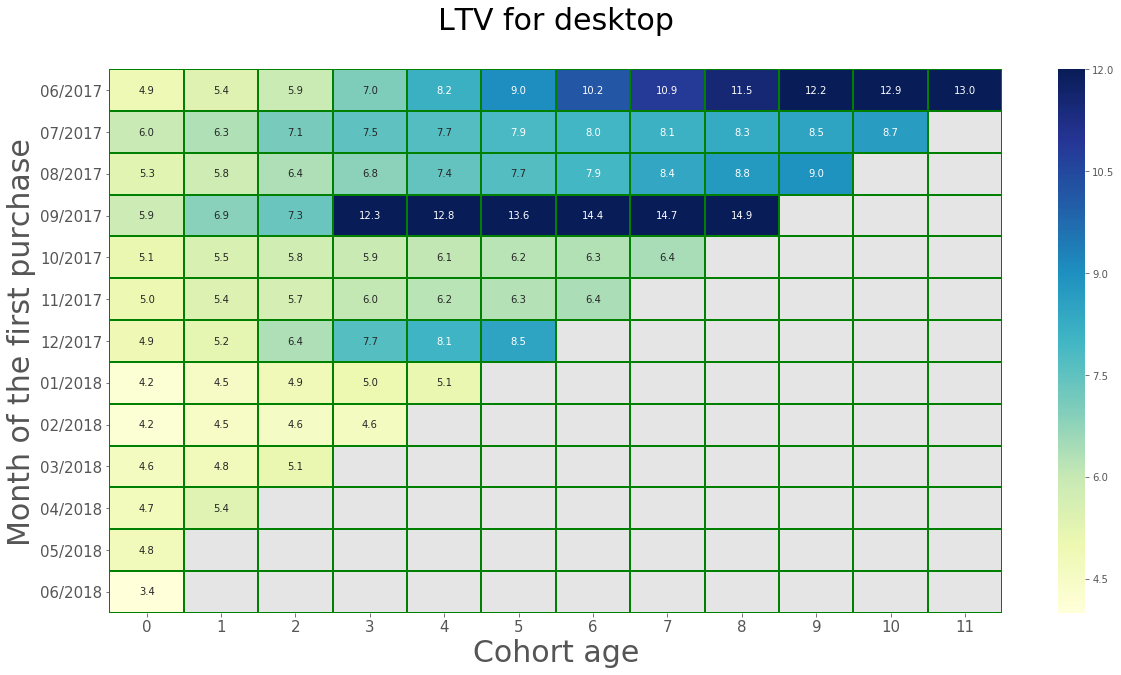

In [43]:
# LTV для ПК
visits_device_category = df_visits.groupby('uid')['device_cat'].first().reset_index()
orders_with_devices_categories = df_orders.merge(visits_device_category, on='uid')
ltv_desktop = orders_with_devices_categories.query('device_cat == "desktop"')
report_desktop = count_ltv(ltv_desktop)
#display(report_desktop.head(1))


desk_output = report_desktop.pivot_table(index='first_order_month', 
                                         columns='age', values='ltv', 
                                         aggfunc='sum').round(4)
desk_output = desk_output.cumsum(axis=1)
desk_output.fillna('')
desk_output
desk_output.index = desk_output.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(desk_output, annot=True, fmt='.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=4, vmax=12)
plt.ylabel('Month of the first purchase', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('LTV for desktop' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

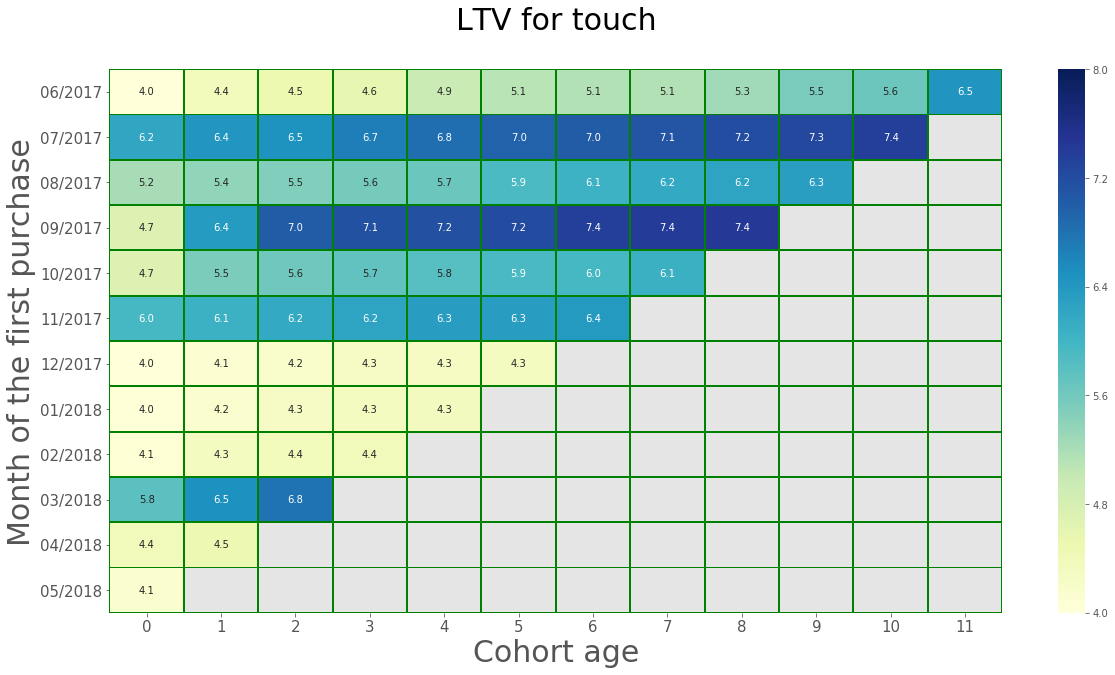

In [44]:
# LTV для мобильных

visits_device_category = df_visits.groupby('uid')['device_cat'].first().reset_index()
ltv_by_devices = df_orders.merge(visits_device_category, on = 'uid')
ltv_touch = orders_with_devices_categories.query('device_cat == "touch"')
ltv_touch['order_month'] = ltv_touch['dt_of_order'].astype('datetime64[M]')
touch_first_order = ltv_touch.groupby('uid').agg({'order_month':'min'}).\
reset_index()
touch_first_order.columns = ['uid','first_order_month']
touch_desktop = ltv_touch.merge(touch_first_order, on = 'uid')
touch_cohort_sizes = touch_first_order.groupby('first_order_month').\
agg({'uid':'nunique'}).reset_index()
touch_cohort_sizes.columns = ['first_order_month', 'n_buyers']
touch_new = pd.merge(ltv_touch, touch_first_order, on = 'uid')
touch_new
touch_cohorts = touch_new.groupby(['first_order_month', 'order_month']).\
agg({'revenue':'sum'}).reset_index()
touch_report = pd.merge(touch_cohort_sizes, touch_cohorts, 
                        on='first_order_month')
margin_rate = 1
touch_report['gp'] = touch_report['revenue'] * margin_rate
touch_report['age'] = (touch_report['order_month'] - 
                       touch_report['first_order_month'])/ np.timedelta64(1, 'M')
touch_report['age'] = touch_report['age'].round().astype('int')
touch_report['ltv'] = touch_report['gp'] / touch_report['n_buyers']

# visualizing 
touch_output = touch_report.pivot_table(index = 'first_order_month', 
columns = 'age', values = 'ltv', aggfunc = 'sum').round(4)
touch_output = touch_output.cumsum(axis = 1)
touch_output.fillna('')
touch_output.index = touch_output.index.strftime('%m/%Y')
plt.figure(figsize = (20,10))
sns.heatmap(touch_output, annot=True, fmt='.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=4, vmax=8)
plt.ylabel('Month of the first purchase', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('LTV for touch' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

desk_output = report_desktop.pivot_table(index='first_order_month', 
                                         columns='age', values='ltv', 
                                         aggfunc='sum').round(4)
desk_output = desk_output.cumsum(axis=1)

ltv для настольных ПК значительно выше, чем для мобильных. средний LTV по месяцам составляет 7,97. LTV второго маркетингового источника удивительно высока в декабре и сентябре (конечно, нам также нужно проверить, сколько денег было потрачено на него за эти два месяца)

<font face='Liberation serif' size=4>**Каковы затраты? В целом / по каждому источнику / по месяцам**</font>

Overall the amount spent on marketing from 2017-06-01 00:00:00 to 2018-05-01 00:00:00 is 329131


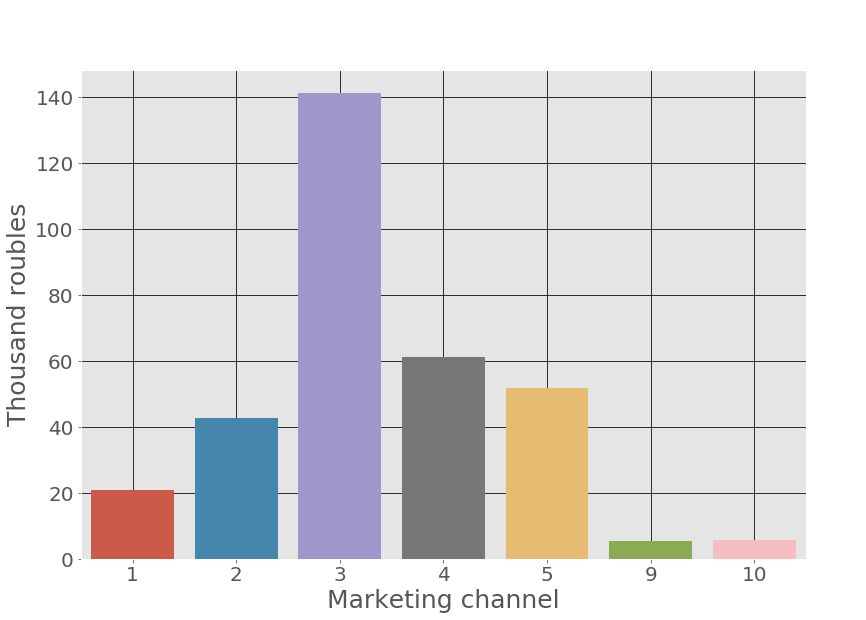

           cost_for_marketing_source
source_id                           
1                             20.833
2                             42.806
3                            141.322
4                             61.074
5                             51.757
9                              5.517
10                             5.822


In [45]:
# сколько потрачено на маркетинг
print('Overall the amount spent on marketing from', 
      df_costs['month_of_commercial'].\
      min(), 'to', df_costs['month_of_commercial'].max(), 'is',
     int(df_costs['cost_for_marketing_source'].sum()))
df_costs_new = df_costs.copy()
df_costs_new.source_id = pd.Categorical(df_costs_new.source_id)
pivot_costs_sources_sum_new = df_costs_new.pivot_table(index='source_id', 
                                                       values='cost_for_marketing_source', 
                                                       aggfunc='sum')
pivot_costs_sources_sum_new['cost_for_marketing_source'] = \
pivot_costs_sources_sum_new['cost_for_marketing_source'] / 1000
plt.figure(figsize=(13, 9))
sns.barplot(x=pivot_costs_sources_sum_new.index, y='cost_for_marketing_source', 
            data=pivot_costs_sources_sum_new)
plt.title('Overall expenses on marketing per  marketing channel' + '\n', fontsize=30)
plt.xlabel('Marketing channel', fontsize=25)
plt.ylabel('Thousand roubles', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()
print(pivot_costs_sources_sum_new)

In [46]:
# Посмотрим, будет ли товар прибыльным
print('Total revenue is', 
      int(df_orders['revenue'].sum()))

Total revenue is 252057


<font face='Liberation serif' size=4>**Товар теряет деньги (или еще не стал прибыльным).**</font>

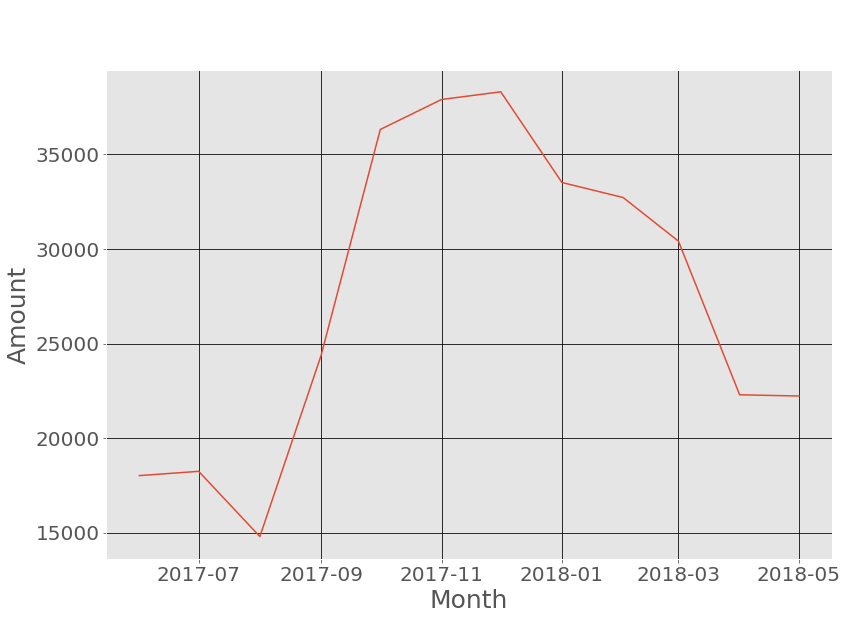

Средняя сумма, потраченная на маркетинг в месяц 27427


In [47]:
# давайте проверим, сколько денег было потрачено на маркетинг ежемесячно
plt.figure(figsize=(13,9))
plt.plot(df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].sum())
plt.title('Monthly marketing costs' + '\n', fontsize=30)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()
print('Средняя сумма, потраченная на маркетинг в месяц', int(
            df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].\
                                               sum().mean()))

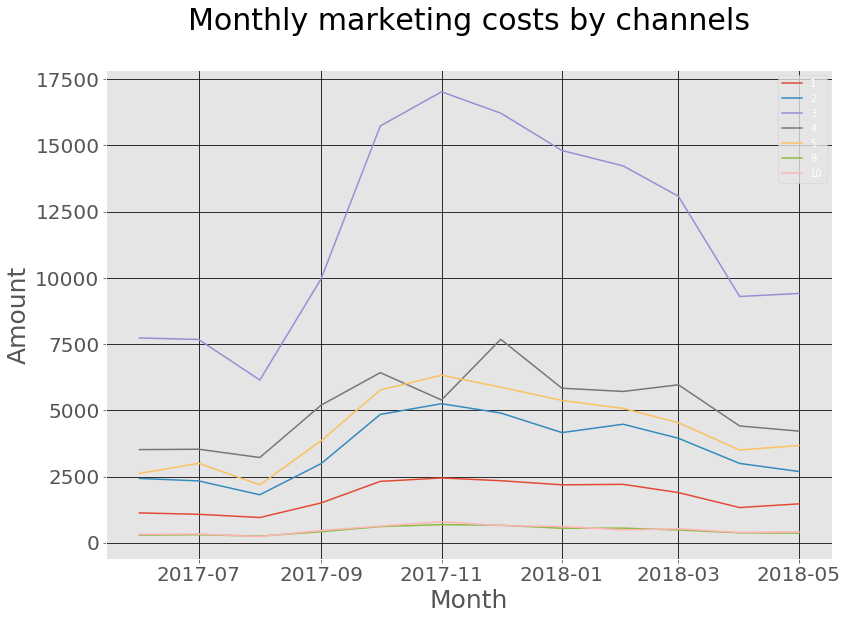

In [48]:
costs_pivot = df_costs.pivot_table(index='month_of_commercial', 
                                   values='cost_for_marketing_source', 
                                   columns='source_id', aggfunc='sum')
plt.figure(figsize=(13,9))
plt.plot(costs_pivot)
plt.legend(costs_pivot.columns)
plt.title('Monthly marketing costs by channels' + '\n', fontsize=30,
         color='black')
plt.xlabel('Month', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()

за почти год на маркетинг было потрачено 329131 рубль, а всего заработано 252057 - проект пока убыточный или вообще убыточный (смотря сколько месяцев живет заказчик)

самый дорогой канал сбыта - третий, на него ушла 141 тысяча рублей, и четвертый (еще один канал, который приносит нам сопоставимое количество посещений сайта) - 61 тысячу. Возможно, одна из причин коммерческого провала нашего продукта заключается в том, что маркетинговые деньги вкладываются не в то место. Возможно, нам нужно вложить больше денег в четвертый и пятый каналы сбыта.

<font face='Liberation serif' size=4>**Стоимость привлечения клиента.**</font>


In [49]:
display(df_costs.head(2))
display(df_orders.head(2))
marketing_sources = df_visits.groupby('uid')['commercial_source_id'].first().reset_index()
orders_with_marketing_sources = df_orders.merge(marketing_sources, on='uid', how='left')
orders_with_sources = pd.merge(orders_with_marketing_sources, df_orders, on=['uid', 
                                                                'dt_of_order', 'revenue'], 
                               how='right')
orders_with_sources
cost_per_source = df_costs.groupby('source_id')['cost_for_marketing_source'].sum().reset_index()
number_of_clients_per_source = orders_with_marketing_sources.\
groupby('commercial_source_id')['uid'].count().reset_index()
number_of_clients_per_source
cost_per_client = cost_per_source.merge(number_of_clients_per_source, left_on='source_id', 
                                        right_on='commercial_source_id', how='left')
cost_per_client['cost_per_client'] = (cost_per_client['cost_for_marketing_source'] / 
                                      cost_per_client['uid'])
print('CAC per marketing channel')
display(cost_per_client[['commercial_source_id', 'cost_per_client']])
print('Средний CAC ', 
      round(cost_per_client['cost_per_client'].mean(), 2), 'тысяч рублей')

,source_id,dt_of_commercial,cost_for_marketing_source,day_of_commercial,week_of_commercial,month_of_commercial,year_of_commercial
0,1,2017-06-01,75.200,2017-06-01,2017-06-01,2017-06-01,2017-01-01
1,1,2017-06-02,62.250,2017-06-02,2017-06-01,2017-06-01,2017-01-01


,dt_of_order,revenue,uid,month_of_order,order_month
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01,2017-06-01


CAC per marketing channel


,commercial_source_id,cost_per_client
0,1,3.119
1,2,5.535
2,3,12.917
3,4,4.987
4,5,5.559
5,9,2.688
6,10,4.013


Средний CAC  5.55 тысяч рублей


<font face='Liberation serif' size=4>**Сколько окупились расходы? (ROI, ROMI)**</font>


Average LTV for 6 months: 7.969052630207336


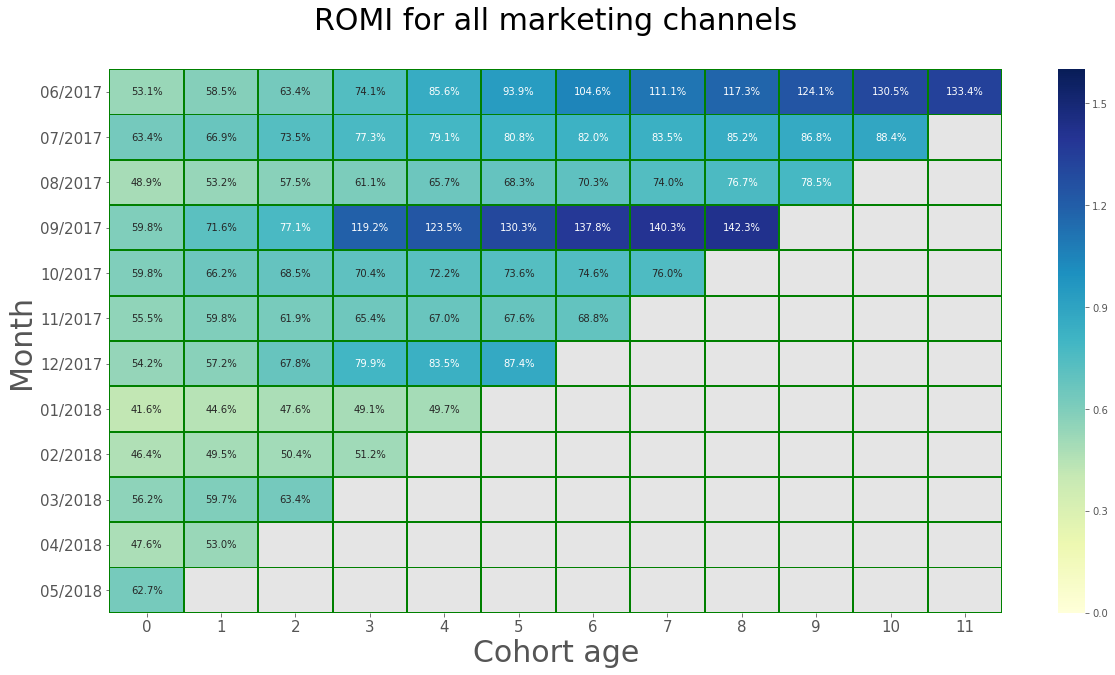

In [50]:
monthly_costs = df_costs.groupby('month_of_commercial').sum()
monthly_costs
report_new = pd.merge(report_ltv, monthly_costs, left_on = 'first_order_month', 
                      right_on = 'month_of_commercial')
report_new['cac'] = report_new['cost_for_marketing_source'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_mark = report_new.pivot_table(index='first_order_month', columns='age', 
                                     values='romi', aggfunc='mean')
print('Average LTV for 6 months:', m6_cum_ltv)
output_mark = output_mark.cumsum(axis=1)
output_mark.index = output_mark.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_mark, fmt='.1%', annot=True, linewidths=1, linecolor='green',
            cmap="YlGnBu", vmin=0, vmax=1.6)
plt.ylabel('Month', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('ROMI for all marketing channels' + '\n', fontsize=30, color='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

#m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
#m6_cum_ltv

Глядя на данные, мы видим, что на распределение нашего реального ROMI сильно повлияли необычные значения показателей, которые продемонстрировали 1-я и 4-я когорты. Поэтому важно понимать, что реальный ROMI для большинства когорт в наших данных будет ниже.

<a class="anchor" id="31-bullet">

In [51]:
costs_monthly_sources = df_costs.groupby(['month_of_commercial', 'source_id'], as_index=False).agg({'cost_for_marketing_source': 'sum'})

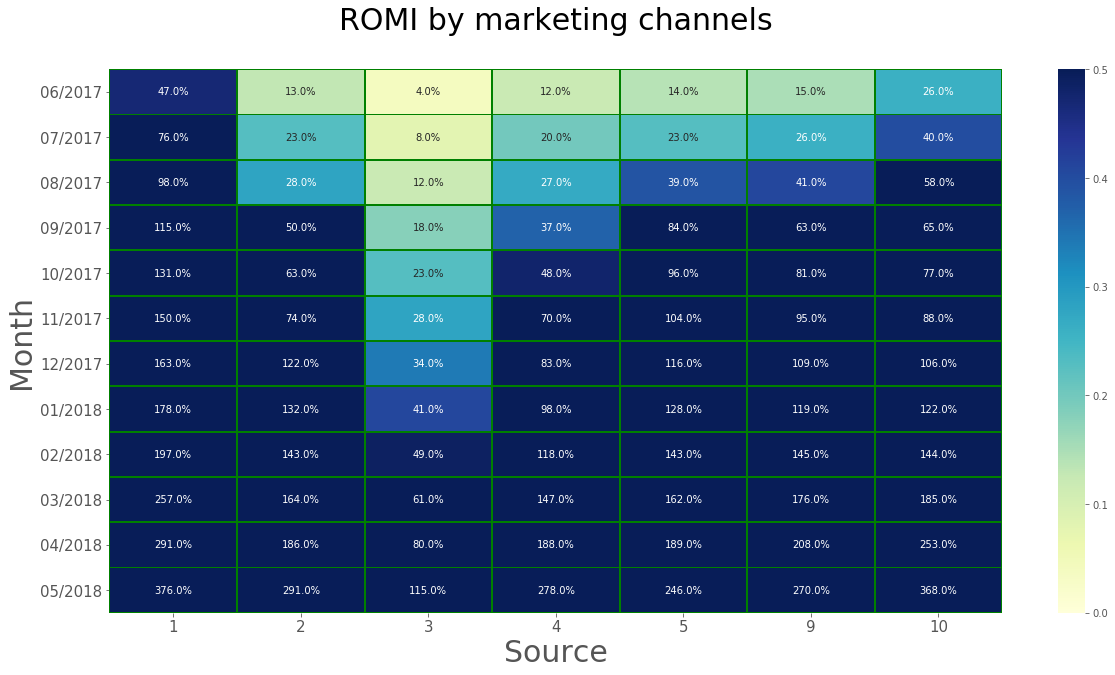

In [52]:
costs_sources = df_costs.groupby('month_of_commercial').sum()
report_source_new = pd.merge(report_source, costs_monthly_sources, left_on=['first_order_month', 'commercial_source_id'],
                             right_on=['month_of_commercial', 'source_id'])
report_source_new['cac'] = (report_source_new['cost_for_marketing_source'] / 
                            report_source_new['n_buyers'])
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
output_source = report_source_new.pivot_table(index='first_order_month', 
                                              columns='commercial_source_id', values='romi',
                                              aggfunc='mean')
output_source = output_source.cumsum(axis = 0).round(2)
output_source.fillna('')
#print(output_source)
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, fmt='.1%', annot=True, linewidths=1, linecolor='green', 
            cmap="YlGnBu", vmin=0, vmax=0.5)
plt.ylabel('Month', fontsize=30)
plt.xlabel('Source', fontsize=30)
plt.title('ROMI by marketing channels' + '\n', fontsize=30, color='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [53]:
report_source_new

,first_order_month,n_buyers,order_month,commercial_source_id,revenue,gp,ltv,month_of_commercial,source_id,cost_for_marketing_source,cac,romi
0,2017-06-01,2023,2017-06-01,1,1378.700,1378.700,0.682,2017-06-01,1,1125.610,0.556,1.225
1,2017-06-01,2023,2017-07-01,1,414.980,414.980,0.205,2017-06-01,1,1125.610,0.556,0.369
2,2017-06-01,2023,2017-08-01,1,419.430,419.430,0.207,2017-06-01,1,1125.610,0.556,0.373
3,2017-06-01,2023,2017-09-01,1,714.240,714.240,0.353,2017-06-01,1,1125.610,0.556,0.635
4,2017-06-01,2023,2017-10-01,1,811.200,811.200,0.401,2017-06-01,1,1125.610,0.556,0.721
...,...,...,...,...,...,...,...,...,...,...,...,...
509,2018-05-01,2988,2018-05-01,3,3256.540,3256.540,1.090,2018-05-01,3,9411.420,3.150,0.346
510,2018-05-01,2988,2018-05-01,4,3802.910,3802.910,1.273,2018-05-01,4,4214.210,1.410,0.902
511,2018-05-01,2988,2018-05-01,5,2094.040,2094.040,0.701,2018-05-01,5,3669.560,1.228,0.571
512,2018-05-01,2988,2018-05-01,9,223.050,223.050,0.075,2018-05-01,9,362.170,0.121,0.616


Как видно из тепловой карты, 3 и 4 когорты самые перспективые. 3 когорта подаёт нам большие надежды, что в скором времени окупится, а 4 когорта уже окупилась



### Заключение:

Мы проанализировали Яндекс. Визиты Афиши, распродажи, затраты. Товар имеет сезонность. Люди значительно увеличивают покупки в ноябре и декабре. Оказалось, что продукт пока убыточный. Несмотря на то, что у нашего продукта достаточно высокий уровень удержания (4,6%), если делать выводы из имеющихся данных, он пока не может приносить нам прибыль.

Тем не менее, из исследования ясно, что у нас есть несколько точек потенциального роста.

Тратятся большие деньги на третий канал, но при этом он скоро выйдет за пределы 50-ти %, что не может не радовать. Радует своей окупаймостью 4 канал, его ROMI составил 52% и исходя из тепловой карты, он и дальше будет расти.